<a href="https://colab.research.google.com/github/lautitorraca/7506R-2C2023-GRUPO24/blob/main/TP2/7506R_TP2_GRUPO24_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 𝔾𝕣𝕦𝕡𝕠 𝟚𝟜 (Merequetengue👍)

  ➢ Torraca Lautaro - 108813

  ➢ Negrotti Gianluca - 108184

  ➢ Marco Tosi - 107237

In [1]:
# !pip install scikit-optimize


### > Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle


### > Lectura de los datasets

In [3]:

url_train = '/content/train_limpio.csv'
url_test = '/content/test_limpio.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)


### XGBOOST

- Division y preprocesamiento de los datos

In [4]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Dividir el dataset en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42)

# Preprocesamiento de los datos con parámetros ajustados
tfidf = TfidfVectorizer(
    max_features=6000,  # Reducido para mejorar el rendimiento
    ngram_range=(1, 2),  # Considerar unigramas y bigramas
    min_df=5,  # Ignorar términos que aparecen en menos de 5 documentos
    max_df=0.9,  # Ignorar términos que aparecen en más del 90% de los documentos
    sublinear_tf=True,  # Aplicar escala logarítmica a la frecuencia de términos
    norm='l1', # Normalización por filas (cada fila suma 1)
    strip_accents='unicode' # Remueve acentos y tildes

)

X_train = tfidf.fit_transform(train_df['review_es_clean']).toarray()
X_test = tfidf.transform(test_df['review_es_clean']).toarray()




- Codifacion del texto con laber encoder

In [5]:
# Codificar la variable objetivo
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentimiento'])
y_test = label_encoder.transform(test_df['sentimiento'])


- Creacion del predictor y ptimizacion de hiperparametros  con BayesSearch cross validation

In [6]:
# Definir el espacio de búsqueda de hiperparámetros

search_space = {
    'max_depth': list(np.arange(10, 20, 50)),
    'learning_rate':list(np.arange(0.1, 0.2, 0.01)),
    'n_estimators': list(np.arange(10, 50, 500)),
    'subsample': list(np.arange(0.05, 0.1, 0.5))
}

# Crear el modelo XGBoost
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss',  n_jobs=-1)

# Crear el objeto BayesSearchCV
opt = BayesSearchCV(
    model,
    search_space,
    n_iter=5,
    scoring=make_scorer(f1_score),
    random_state=42,
    cv=2
)

# Ejecutar la búsqueda bayesiana
opt.fit(X_train, y_train)



BayesSearchCV(cv=2,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=-1, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=5, random_state=42, scoring=make_scorer(f1_score),
              search_spaces={'learning_rate': [0.1, 0.11, 0.12, 0.13,
                                               0.13999999999999999,
                                               0.14999999999999997,
                                               0.15999999999999998,
                                               0.16999999999999998,
                                               0.17999999999999997,
                                               0.18999999999999995],
                             'max_depth': [10], 'n_estimators': [10],
                             'subsample': [0.05]})

- Muestra de los mejores hiperparametros y entranmeinto del modelo

In [7]:
# Mejores parámetros encontrados
print("Mejores parámetros: ", opt.best_params_)

# Entrenar el modelo con los mejores parámetros
best_model = XGBClassifier(**opt.best_params_, objective='binary:logistic', eval_metric='logloss')
best_model.fit(X_train, y_train)


Mejores parámetros:  OrderedDict([('learning_rate', 0.16999999999999998), ('max_depth', 10), ('n_estimators', 10), ('subsample', 0.05)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16999999999999998, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- Evaluacion del modelo y muestra de la matriz de confusion

In [8]:
# Hacer predicciones y evaluar el modelo
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")



Exactitud del modelo: 74.94%
F1 Score: 0.76


Matriz de confusión:


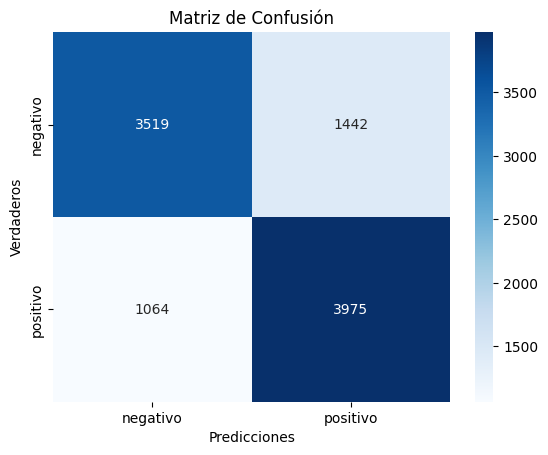

In [9]:
# Evaluar el modelo
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()


In [10]:
# Imprimir métricas individuales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7494
Precision: 0.7338
Recall: 0.7888
F1 Score: 0.7603


- Guardado del modelo con pickle

In [13]:
import pickle

# Guardar el modelo XGBoost
best_model.save_model('xgboost_optimizado.json')

# Descargar los archivos (funciona en Google Colab)
try:
    from google.colab import files
    files.download('xgboost_optimizado.json')

except ImportError:
    print("La función de descarga solo funciona en entornos como Google Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> Prediccion con el dataset de Test

In [12]:


test['review_es_clean'] = test['review_es_clean'].astype(str)

# Transformar las características de prueba con el TfidfVectorizer
test_features = tfidf.transform(test['review_es_clean'])

# Hacer predicciones con el modelo
test_predictions = best_model.predict(test_features)

# Crear un DataFrame con los resultados
output = pd.DataFrame(zip(test["ID"], label_encoder.inverse_transform(test_predictions)), columns=['ID', 'sentimiento'])

# Guardar las predicciones en un archivo CSV
output.to_csv('prediccion_XGBoost.csv', index=False)

# Descargar el archivo de predicciones (esto funcionará en entornos como Jupyter o Google Colab)
try:
    from google.colab import files
    files.download('prediccion_XGBoost.csv')
except ImportError:
    print("La función de descarga solo funciona en entornos como Google Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>